In [39]:
import sys
import os
import os.path
import fnmatch
from lxml import etree
from lxml.etree import tostring
import re
from collections import defaultdict
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pylab import plot
import pickle
import re
import matplotlib.patches as mpatches
from nltk.tokenize import word_tokenize

In [82]:
def process_files(list_of_files, path_in):
    
    words_dict=defaultdict(list)
    length_dict=defaultdict(list)
    chaps_dict=defaultdict(list)
    divs_dict=defaultdict(list)
    plot_words=OrderedDict()
    plot_chaps=OrderedDict()
    plot_div1=OrderedDict()
    plot_div2=OrderedDict()
    plot_div3=OrderedDict()
    plot_length=OrderedDict()
    filtered=list()
    bugs=list()
    stats=defaultdict(list)
    
    print("Processing "+str(len(list_of_files))+" files. Please wait, this might take some time.")

    for tmpFile in list_of_files:

        tmpFile=tmpFile.replace("/",":")
        fullPath=path_in+tmpFile

        print("\nProcessing file "+tmpFile)

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)

        #yearKey=int(tmpFile[:3]+"0")
            yearKey=int(tmpFile[:4])

            words_dict=num_words(words_dict,tree, yearKey, bugs, tmpFile)
            #print(words_dict.keys())
            chaps_dict=num_chapters(chaps_dict,tree,yearKey, bugs,tmpFile)
            
            divs_dict=num_divs(divs_dict, tree, yearKey, bugs, tmpFile)
            
            length_dict=length(length_dict, tree.getroot(), yearKey)
            

    plot_words=words_for_plot(words_dict, plot_words)
    plot_chaps=words_for_plot(chaps_dict, plot_chaps)
    plot_length=words_for_plot(length_dict, plot_length)
    plot_div1=divs_for_plot(divs_dict, plot_div1,1)
    plot_div2=divs_for_plot(divs_dict, plot_div2,2)
    plot_div3=divs_for_plot(divs_dict, plot_div3,3)
    #print(bugs)
    fit_words = lin_reg(plot_words)
    fit_chaps = lin_reg(plot_chaps)
    
    stats["chapter"].append(fit_chaps)
    stats["chapter"].append(plot_chaps)
    stats["word"].append(fit_words)
    stats["word"].append(plot_words)
    stats["divs"].append(plot_div1)
    stats["divs"].append(plot_div2)
    stats["divs"].append(plot_div3)
    stats["length"].append(plot_length)
    
    return stats

    #del filtered
    del words_dict
    del chaps_dict
    del plot_words
    del plot_chaps

In [5]:
def lin_reg(series):

    x = np.array(list(series.keys()))
    y = np.array(list(series.values()))

    x = sm.add_constant(x)

    return sm.OLS(y, x).fit()

In [6]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [7]:
def plot_stats (fit, plot,limitsX,limitsY, sliding, mycolor, title):
    x1 = list(plot.keys())[0]
    x2 = list(plot.keys())[-1]
    y1 = fit.predict()[0]
    y2 = fit.predict()[-1]
    x = np.array(list(plot.keys()))
    y = np.array(list(plot.values()))
    #print(len(plot.values()))
    yMA = movingaverage(y,sliding)
    plt.figure(figsize=(10, 6))
    plt.plot(list(plot.keys()), list(plot.values()))
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=5,color=mycolor)
    plt.title(title)
    plt.plot([x1, x2], [y1, y2], color='gray', linewidth=0.5)
    #plt.xlim(min(plot.keys()),max(plot.keys()))
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    #print(plot.keys())
    plt.show()

In [110]:
def simple_plot (plot, limitsX, limitsY, sliding, mycolor, title):
    plt.figure(figsize=(10, 6))
    x = np.array(list(plot.keys()))
    y = np.array(list(plot.values()))
    yMA = movingaverage(y,sliding)
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=5,color=mycolor)
    plt.plot(x,y)
    plt.title(title)
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    plt.show()

In [8]:
def multiple_plots (stats):
    plt.figure(figsize=(10, 6))
    for name in stats.keys():
        x=np.array(list(stats[name]['word'][1].keys()))
        y=np.array(list(stats[name]['word'][1].values()))
        yMA = movingaverage(y,5)
        plt.plot(x[len(x)-len(yMA):],yMA,label=name[1:])
        plt.ylim(min(stats[name]['word'][1].keys()),30000)
        plt.xlim(1800,1910)
    plt.legend(loc='upper left')
    plt.title("nombre moyen de mots par chapitre")
    plt.show()
    plt.figure(figsize=(10, 6))
    for name in stats.keys():
        x=np.array(list(stats[name]['chapter'][1].keys()))
        y=np.array(list(stats[name]['chapter'][1].values()))
        yMA = movingaverage(y,5)
        plt.plot(x[len(x)-len(yMA):],yMA,label=name[1:])
        plt.ylim(0,80)
        plt.xlim(1800,1910)
    plt.legend(loc='upper left')
    plt.title("nombre moyen de chapitres")
    plt.show()

In [36]:
def hierarchy_plots (plot,limitsX,limitsY, sliding, mycolor, title):
    plt.figure(figsize=(10, 6))
    x = np.array(list(plot[0].keys()))
    y = np.array(list(plot[0].values()))
    yMA = movingaverage(y,sliding)
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=2,color=mycolor[0])
    x1 = np.array(list(plot[1].keys()))
    y1 = np.array(list(plot[1].values()))
    yMA1 = movingaverage(y1,sliding)
    plt.plot(x1[len(x1)-len(yMA1):],yMA1,linewidth=2,color=mycolor[1])
    x2 = np.array(list(plot[2].keys()))
    y2 = np.array(list(plot[2].values()))
    yMA2 = movingaverage(y2,sliding)
    plt.plot(x2[len(x2)-len(yMA2):],yMA2,linewidth=2,color=mycolor[2])
    plt.legend(loc='upper left')
    plt.title(title)
    patch1 = mpatches.Patch(color=color[0], label='niveau 1')
    patch2 = mpatches.Patch(color=color[1], label='niveau 2')
    patch3 = mpatches.Patch(color=color[2], label='niveau 3')
    plt.legend(handles=[patch1, patch2, patch3])
    plt.show()

In [10]:
def num_words (words_dict,tree,yearKey,bugs,tmpFile):
    execute=False
    words=list()
    if tree.findall(".//div[@type='chapter']"):
        for chapter in tree.findall(".//div[@type='chapter']"):
            tmp="".join(chapter.itertext())
            numWords=len(re.split('[\n\s]+',tmp))
            words.append(numWords)
            execute=True
            #print(chapter.attrib["title"])
            #print(numWords)
    elif tree.findall(".//div[@type='part']"):
        for chapter in tree.findall(".//div[@type='part']"):
            tmp="".join(chapter.itertext())
            numWords=len(re.split('[\n\s]+',tmp))
            words.append(numWords)
            execute=True
    
    else :
        for p in tree.findall(".//p"):
            tmp="".join(p.itertext())
            numWords=len(re.split('[\n\s]+',tmp))
            words.append(numWords)
            execute=True
    
    #else :
        #bugs.append(tmpFile+" ; ")
        #execute=False
    
    if execute==True:
        average=sum(words)/len(words)
        words_dict[yearKey].append(average)
    return words_dict

In [54]:
def length (length_dict, node, yearKey):
    text="".join([x for x in node.itertext()])
    length_dict[yearKey].append(len(word_tokenize(text, language='french')))
    return length_dict

In [11]:
def num_chapters (chaps_dict,tree, yearKey,bugs,tmpFile):
    execute=False
    chapters=list()
    if tree.findall(".//div[@type='chapter']"):
        num_chaps=len(tree.findall(".//div[@type='chapter']"))
        execute=True
        #print("Pour l'année : "+str(yearKey))
        #print(num_chaps)
    elif tree.findall(".//div[@type='part']"):
        num_chaps=len(tree.findall(".//div[@type='part']"))
        execute=True
    
    else :
        bugs.append(tmpFile+" ; ")
        execute=False
    
    if execute==True:
        chaps_dict[yearKey].append(num_chaps)
        #print(len(chap_dict[yearKey]))
        #print(chap_dict[yearKey])
    else :
        chaps_dict[yearKey].append(0)
    return chaps_dict

In [12]:
def num_divs (divs_dict,tree, yearKey,bugs,tmpFile):
    execute=False
    chapters=list()
    if tree.findall(".//div[@type='chapter']") and tree.findall(".//div[@type='part']") and tree.findall(".//div[@type='book']"):
        num_divs=3
    elif tree.findall(".//div[@type='chapter']") and tree.findall(".//div[@type='part']"):
        num_divs=2
    elif tree.findall(".//div[@type='chapter']") or tree.findall(".//div[@type='part']"):
        num_divs=1
    else :
        num_divs=0
    
    divs_dict[yearKey].append(num_divs)
    
    return divs_dict

In [13]:
def words_for_plot (words_dict, plot_words):
    for year in sorted(words_dict.keys()):
        if len(words_dict[year])>0:
        #moyenne nombre de mots par année
            plot_words[year]=sum(words_dict[year])/len(words_dict[year])
    return plot_words

In [23]:
def divs_for_plot (divs_dict, plot_divs, hierarchy):
    #print(len(divs_dict.keys()))
    for year in sorted(divs_dict.keys()):
        plot_divs[year]=divs_dict[year].count(hierarchy)
    return plot_divs

In [15]:
def by_attribute (list_of_files, path_in, lxml_string):
    filtered=list()
    for tmpFile in list_of_files:

        fullPath=path_in+tmpFile.replace("/",":")

        #print("\nProcessing file "+tmpFile)

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)
        
            if tree.findall(lxml_string):
                filtered.append(tmpFile)
    return filtered

In [16]:
def by_element_value (list_of_files, path_in, lxml_string, value_to_check):
    filtered=list()
    for tmpFile in list_of_files:

        fullPath=path_in+tmpFile.replace("/",":")

        #print("\nProcessing file "+tmpFile)

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)
        
            if tree.findall(lxml_string):
                for elem in tree.findall(lxml_string):
                    if elem.text and value_to_check in elem.text:
                        filtered.append(tmpFile)
    return filtered

In [17]:
def by_name (list_of_files, path_in, author):
    files_by_author=list()
    for tmpFile in list_of_files:
        fullPath=path_in+tmpFile.replace("/",":")
        if os.path.isfile(fullPath):
            result = re.search('[0-9]{4}(.*)_', tmpFile)
            name= result.group(1)
            if author in name:
                files_by_author.append(tmpFile)
    return files_by_author

In [123]:
%matplotlib inline
#path_to_folder='/home/odysseus/Bureau/ANR/code/corpus/corpus_restreint/'
path_to_folder='/home/odysseus/Bureau/ANR/romans/'
authors=['_Dumas','_Zola','_Maupassant','_Sand-G',"_Ponson","_Flaubert"]

print("Statistiques globales : ")
files_list=fnmatch.filter(os.listdir(path_to_folder), '*.xml')

#stats_authors=OrderedDict()
#for author in authors:
    #names=by_name(files_list, path_to_folder,author)
    #stats_authors[author]=process_files(names, path_to_folder)
#pickle.dump(stats_authors, open("stats_authors","wb"))
    
stats_global=process_files(files_list, path_to_folder)

#canon_list=by_attribute(files_list, path_to_folder,".//profileDesc[@tag='non-canon']")
#stats_canon=process_files(canon_list, path_to_folder)

#genre_list=by_element_value(files_list, path_to_folder,".//term","populaire")
#stats_genre=process_files(genre_list, path_to_folder)

pickle.dump(stats_global, open("stats_global","wb"))
#pickle.dump(stats_canon, open("stats_rest_non-canon","wb"))
#pickle.dump(stats_genre, open("stats_global_populaire","wb"))

Statistiques globales : 
Processing 2900 files. Please wait, this might take some time.

Processing file 1850_Dumas-Alexandre_Le-Vicomte-de-Bragelonne.xml

Processing file 2014_Saussure-Horace-Bénédict-de_L'Ascension-du-Mont-Blanc.xml

Processing file 2011_Chandernagor-Françoise_Les-enfants-d'Alexandrie.xml

Processing file 2013_Stolz-Madame-de_Les-Poches-de-mon-oncle.xml

Processing file 1966_San-Antonio_Faut-être-logique.xml

Processing file 2014_Volodine-Antoine_Terminus-radieux.xml

Processing file 1920_Toulet-Paul-Jean_La-jeune-fille-verte-roman.xml

Processing file 1874_Achard-Amédée_Envers-et-contre-tous.xml

Processing file 1996_Daeninckx-Didier_Nazis-dans-le-métro.xml

Processing file 1881_ Verne-Jules_Dix-heures-de-chasse.xml

Processing file 1910_Ivoi-Paul-d'_Millionnaire-malgré-lui-(tome-1).xml

Processing file 1961_Troyat-Henri_La-gloire-des-vaincus.xml

Processing file 2013_Scholl-Aurélien_Les-Gens-tarés.xml

Processing file 1898_Ivoi-Paul-d'_La-Capitaine-Nilia.xml

Proce


Processing file 2006_Nothomb-Amélie_Journal-d'Hirondelle.xml

Processing file 1884_Boisgobey-Fortuné-du_La-voilette-bleue.xml

Processing file 1890_Ohnet-Georges_L'Ame-de-Pierre.xml

Processing file 1877_Malot-Hector_Comte-du-Pape.xml

Processing file 1971_Tournier-Michel_Vendredi-ou-la-vie-sauvage.xml

Processing file 1973_Barjavel-René_Le-Grand-Secret.xml

Processing file 1942_Vercors_Le-silence-de-la-mer.xml

Processing file 1991_Germain-Sylvie_L'Enfant-Méduse.xml

Processing file 1944_Queneau-Raymond_Loin-De-Rueil.xml

Processing file 1853_Zaccone-Pierre_Éric-le-mendiant.xml

Processing file 1930_Galopin-Arnould_Le-sergent-Bucaille.xml

Processing file 1861_Erckmann-Chatrian_Confidences-d'un-joueur-de-clarinette.xml

Processing file 1880_Létang-Louis_La-Belle-hôtesse-par-Louis-Létang-(1883).xml

Processing file 1878_Révillon-Tony_Noémi-par-Tony-Révillon-(1878).xml

Processing file 1908_Colette_Les-Vrilles-de-la-vigne.xml

Processing file 1973_Simon-Claude_Triptyque.xml

Processing


Processing file 2016_Échenoz-Jean_Envoyée-spéciale.xml

Processing file 1896_Jarry-Alfred_L'Autre-Alceste.xml

Processing file 1847_Gautier-Théophile_Les-roués-innocents.xml

Processing file 1888_Zola-Émile_Le-rêve.xml

Processing file 2004_Foenkinos-David_Le-potentiel-érotique-de-ma-femme.xml

Processing file 1854_Sue-Eugène_Les-Mystères-du-peuple-Tome-X.xml

Processing file 1880_Glouvet-Jules-de_Le-Forestier-par-Jules-de-Glouvet-(1880).xml

Processing file 2005_Bégaudeau-François_Un-démocrate-Mick-Jagger.xml

Processing file 1974_Sagan-Françoise_Un-profil-perdu.xml

Processing file 1884_Sernhac-Jocelyn_Jocelyn-Sernhac.-Le-Crédit-gaulois-histoire-d'une-femme-nue-(1884).xml

Processing file 1973_Sarraute-Nathalie_C'est-Beau.xml

Processing file 1904_Verne-Jules_Un-drame-en-Livonie.xml

Processing file 2012_Chandernagor-Françoise_Les-Dames-de-Rome.xml

Processing file 1868_Erckmann-Chatrian_Histoire-d'un-paysan-II.xml

Processing file 1884_Poitevin-B._Le-Pêcheur-de-l'île-de-La-Borde-pa


Processing file 1862_Féval-Paul-(père)_Jean-Diable-Tome-I.xml

Processing file 1871_Dumas-Alexandre-Père_La-fille-du-marquis-I.xml

Processing file 1842_Karr-Alphonse_Midi-à-quatorze-heures-Histoire-d'un-voisin—Voyage-dans-Paris—Une-visite-à-l'Arsenal—Un-homme-et-une-femme.xml

Processing file 1949_Simenon-Georges_L'amie-de-madame-Maigret.xml

Processing file 2001_Simon-Claude_Le-tramway.xml

Processing file 1850_Sand-George_Nanon.xml

Processing file 2013_Heures-Marie-d'_Le-Désert-dans-Paris.xml

Processing file 1956_Camus-Albert_La-Chute.xml

Processing file 2000_Djian-Philippe_Vers-chez-les-blancs.xml

Processing file 2012_Adam-Olivier_Les-Lisières.xml

Processing file 1934_Simenon-Georges_Maigret.xml

Processing file 1978_Robbe-Grillet-Alain_Souvenirs-du-triangle-d'or.xml

Processing file 1995_Millet-Richard_La-gloire-des-pythre.xml

Processing file 1892_Schwob-Marcel_Le-roi-au-masque-d’or.xml

Processing file 2013_Beaufort-d'-Hautpoul-Anne-Marie-de_Le-Page-et-la-romance-par-Mme-l


Processing file 1971_Simenon-Georges_Maigret-et-l'homme-tout-seul.xml

Processing file 1877_Aimard-Gustave-Auriac-Jules-Berlioz-d'_L'Aigle-Noir-des-Dacotahs.xml

Processing file 2013_Stolz-Madame-de_La-famille-Coquelicot.xml

Processing file 1899_Mirbeau-Octave_Le-Jardin-des-supplices.xml

Processing file 1964_Simenon-Georges_La-patience-de-Maigret.xml

Processing file 1931_Nizan-Paul_Aden-Arabie.xml

Processing file 2013_Decourcelle-Pierre_Mam'zelle-Misère-:-roman-inédit.xml

Processing file 1992_Bergounioux-Pierre_L’orphelin.xml

Processing file 2013_Vesco-Marie-Delorme-Mme-Léon_Les-Filles-du-clown-(Rita).xml

Processing file 1877_Bouvier-Alexis_Le-Domino-rose-par-Alexis-Bouvier-(1877).xml

Processing file 1880_Ulbach-Louis_Le-Crime-de-Martial-par-Louis-Ulbach-(1880).xml

Processing file 1934_Yourcenar-Marguerite_Denier-du-rêve.xml

Processing file 1853_Dumas-Alexandre-Père_Les-Mohicans-de-Paris-1.xml

Processing file 1893_Lemonnier-Camille_L'Homme-qui-tue-les-femmes.xml

Processing


Processing file 1911_Rolland-Romain_Jean-Christophe-Tome-IX-Le-buisson-ardent.xml

Processing file 2013_Bégaudeau-François_Le-moindre-mal.xml

Processing file 1973_Déon-Michel_Un-Taxi-mauve.xml

Processing file 1946_Vian-Boris_J'irai-cracher-sur-vos-tombes.xml

Processing file 1868_Erckmann-Chatrian_Histoire-d'un-paysan-I.xml

Processing file 2013_Dhanys-Marcel_Monsieur-de-Voltaire-précepteur-de-Marie-Corneille.xml

Processing file 1843_Sue-Eugène_Les-Mystère-de-Paris-Tome-I.xml

Processing file 1896_Loti-Pierre_Ramuntcho.xml

Processing file 1998_Houellebecq-Michel_Les-particules-élémentaires.xml

Processing file 1845_Dumas-Alexandre_Le-Chevalier-de-Maison-Rouge.xml

Processing file 1934_Aragon-Louis_Les-Cloches-de-Bâle.xml

Processing file 1908_France-Anatole_Les-contes-de-Jacques-Tournebroche.xml

Processing file 2013_Nodier-Charles_Inès-de-Las-Sierras.xml

Processing file 1923_Istrati-Panaït_Les-récits-d’Adrien-Zograffi-I.xml

Processing file 2012_Lemaître-Pierre_Sacrifices.xml

P


Processing file 1838_Kock-Paul-de_Madeleine.xml

Processing file 2014_Améro-Constant_Le-tour-de-France-d'un-petit-Parisien.xml

Processing file 1811_Chateaubriand-François-René-de_Oeuvres-complètes-de-Chateaubriand.-augmentées-d'un-essai-sur-la-vie-et-les-ouvrages-de-l'auteur-[par-Delandine-de-Saint-Esprit]-Volume-7-(1851-1852).xml

Processing file 2011_Beigbeder-Frédéric_99-Francs.xml

Processing file 1923_Proust-Marcel_À-la-recherche-du-temps-perdu-IX.xml

Processing file 1877_Malot-Hector_Ida-et-Carmelita.xml

Processing file 2012_Jouet-Jacques_La-seule-fois-de-l'amour.xml

Processing file 1875_Houssaye-Arsène_Arsène-Houssaye.-Les-Mille-et-une-nuits-parisiennes...-(1879).xml

Processing file 1857_Dumas-Alexandre_Le-meneur-de-loups.xml

Processing file 1946_Simenon-Georges_Maigret-et-l'inspecteur-Malgracieux.xml

Processing file 1885_Sauton-Georges-Brétigny-Pierre_Georges-Sauton-et-Pierre-Brétigny.-Mouchot-"la-Fille"...-(1885).xml

Processing file 1899_Noir-Louis_En-route-vers-le-Pô


Processing file 1925_Cendrars-Blaise_L'or.xml

Processing file 1876_Erckmann-Chatrian_L'ami-Fritz.xml

Processing file 1842_Hugo-Victor_Le-Rhin-Tome-IV.xml

Processing file 2014_Ferney-Alice_Le-Règne-du-vivant.xml

Processing file 1970_Simenon-Georges_La-folle-de-Maigret.xml

Processing file 2010_Nothomb-Amélie_Une-forme-de-vie.xml

Processing file 1932_Lallier-Joseph_Le-spectre-menaçant.xml

Processing file 1849_Dumas-Alexandre_Le-Collier-de-la-reine.xml

Processing file 2015_Despentes-Virginie_Vernon-Subutex-T1.xml

Processing file 1909_Boylesve-René_La-jeune-fille-bien-élevée.xml

Processing file 1870_Daudet-Alphonse_Le-Nabab.xml

Processing file 1886_Mary-Jules_Roger-la-honte.xml

Processing file 1865_Goncourt-Edmond-et-Jules-de_Germinie-Lacerteux.xml

Processing file 2008_Grangé-Jean-Christophe_Miserere.xml

Processing file 2016_Perec-Georges_L'Attentat-de-Sarajevo.xml

Processing file 1965_San-Antonio_Mange-et-tais-toi.xml

Processing file 1952_San-Antonio_Des-clientes-pour-la-m


Processing file 2013_Bastide-Jenny_Le-Marquis-Roger.xml

Processing file 1890_Richebourg-Émile_Les-Amours-de-Village.xml

Processing file 1879_Houssaye-Arsène_Histoires-romanesques-par-Arsène-Houssaye-(1879).xml

Processing file 1990_Perec-Georges_Je-suis-né.xml

Processing file 2009_Bergounioux-Pierre_Une-chambre-en-Hollande.xml

Processing file 1886_Adam-Paul_La-glèbe.xml

Processing file 1993_Modiano-Patrick_Chien-de-printemps.xml

Processing file 1944_Aragon-Louis_Aurélien.xml

Processing file 1897_Mary-Jules_Les-Filles-de-la-pocharde.xml

Processing file 1848_Dumas-Alexandre_La-dame-aux-camélias.xml

Processing file 1879_Bouvier-Alexis_La-Belle-Grêlée.xml

Processing file 1981_Simon-Claude_Les-Géorgiques.xml

Processing file 2013_Colomb-Joséphine_La-Fille-de-Carilès.-Le-petit-prince-Ulrich.-Nedji-la-Bohémienne.-La-bonne-Mitche.xml

Processing file 1997_Modiano-Patrick_Dora-Bruder.xml

Processing file 1944_Simenon-Georges_Jeumont-51-minutes-d'arrêt-.xml

Processing file 1947_Simon


Processing file 1880_Vignon-Claude_Une-femme-romanesque.-Adrien-Malaret.-L'Exemple.-Par-Claude-Vignon-(1881).xml

Processing file 2011_Grangé-Jean-Christophe_Le-passager.xml

Processing file 1910_Farrère-Claude_Les-petites-alliées.xml

Processing file 1897_Ivoi-Paul-d'_Jean-Fanfare.xml

Processing file 1941_Jaloux-Edmond_Les-Visiteurs.xml

Processing file 1995_Le-Clézio-Jean-Marie-Gustave_La-Quarantaine.xml

Processing file 1876_Sand-George_Contes-d’une-grand-mère.xml

Processing file 1905_Rebell-Hugues_Gringalette.xml

Processing file 2013_Inconnu_Le-rocher.xml

Processing file 2011_Jonquet-Thierry_Vampires.xml

Processing file 1895_Rameau-Jean_Yan.xml

Processing file 1926_Bazin-René_Baltus-le-Lorrain.xml

Processing file 1967_San-Antonio_L'archipel-des-malotrus.xml

Processing file 1911_Bazin-René_Davidée-Birot.xml

Processing file 1779_Restif-de-la-Bretonne-Nicolas-Edme_La-Vie-de-mon-père.xml

Processing file 1895_Ivoi-Paul-d'_Le-Sergent-Simplet-à-travers-les-colonies-françaises.x


Processing file 1857_Sue-Eugène_Les-Mystères-du-peuple-Tome-XVI.xml

Processing file 2014_Bouraoui-Nina_Standard.xml

Processing file 1931_Simenon-Georges_Le-pendu-de-Saint-Pholien.xml

Processing file 1957_Pagnol-Marcel_La-Gloire-de-mon-père.xml

Processing file 1909_Zévaco-Michel_Les-Amants-de-Venise.xml

Processing file 1882_Guy-de-Maupassant_Mademoiselle-Fifi.xml

Processing file 1946_Béalu-Marcel_Journal-d'un-mort.xml

Processing file 1882_Verly-Hippolyte_Hippolyte-Verly.-Spada-la-Rapière-(1882).xml

Processing file 1871_Dumas-Alexandre-Père_La-fille-du-marquis-II.xml

Processing file 1864_Féval-Paul-(père)_Les-habits-noirs-Tome-II-Coeur-d'acier.xml

Processing file 1974_Sagan-Françoise_Des-yeux-de-soie.xml

Processing file 1907_Zévaco-Michel_Les-Pardaillan.xml

Processing file 1967_San-Antonio_Viva-Bertaga.xml

Processing file 1921_Pagnol-Marcel_La-Petite-Fille-aux-yeux-sombres-suivi-de-Les-secrets-de-Dieu.xml

Processing file 1994_Laurent-Jacques_L'inconnu-du-temps-qui-passe.xm


Processing file 1922_Rolland-Romain_L'âme-enchantée-Annette-et-Sylvie-Volume-1.xml

Processing file 1916_Leblanc-Maurice_L'Éclat-d'obus.xml

Processing file 2016_Claudel-Philippe_L'arbre-du-pays-Toraja.xml

Processing file 2013_Noussanne-Henri-de_Jasmin-Robba-suivi-de-:-Pierrefonds-dans-l'histoire.xml

Processing file 2013_Quix-E._La-Journée-d'un-philosophe.xml

Processing file 1895_France-Anatole_Le-Jardin-d'Epicure.xml

Processing file 1941_Simenon-Georges_Les-caves-du-Majestic.xml

Processing file 1865_Erckmann-Chatrian_Histoire-d’un-homme-du-peuple.xml

Processing file 1948_Simenon-Georges_La-première-enquête-de-Maigret.xml

Processing file 1927_Gide-André_Les-Faux-monnayeurs.xml

Processing file 2003_Modiano-Patrick_Accident-nocturne.xml

Processing file 1890_Karr-Alphonse_La-Maison-de-l'Ogre.xml

Processing file 1888_Courteline-Georges_Les-femmes-d’amis.xml

Processing file 1889_Loti-Pierre_Au-Maroc.xml

Processing file 2013_Rousseau-Jean-Jacques_La-nouvelle-Héloïse.xml

Process


Processing file 2015_Forest-Philippe_Aragon.xml

Processing file 1816_Barthélemy-Hadot-Marie-Adélaïde_Les-vénitiens-ou-Le-capitaine-français-par-Mme-Barthélemy-Hadot-Tome-1-(1817).xml

Processing file 1883_Pontmartin-Armand-de_Les-Corbeaux-du-Gévaudan-par-A.-de-Pontmartin-(1883).xml

Processing file 1839_Stendhal_Chroniques-italiennes.xml

Processing file 2003_Rufin-Jean-Christophe_Globalia.xml

Processing file 1882_Hugo-Victor_L’archipel-de-la-Manche.xml

Processing file 2013_Laurie-André_La-Vie-de-collège-dans-tous-les-temps-et-dans-tous-les-pays.xml

Processing file 2013_Pigault-Lebrun_Le-coureur-d'aventures-:-l'homme-à-projets.xml

Processing file 1845_Sand-George_Le-meunier-d’Angibault.xml

Processing file 2015_Nothomb-Amélie_Le-crime-du-comte-Neville.xml

Processing file 1942_Camus-Albert_L'étranger.xml

Processing file 1997_Millet-Richard_L'amour-des-trois-soeurs-Piale.xml

Processing file 2013_Valter-Adolphine-De-Jonge-Mme_Les-Confessions-de-la-comtesse-d'Aquilar-étude-histori


Processing file 1970_Simenon-Georges_Maigret-et-l'indicateur.xml

Processing file 1926_Kessel-Joseph_Les-Captifs.xml

Processing file 1981_Villard-Marc_Corvette-de-nuit.xml

Processing file 2003_Millet-Richard_Ma-vie-parmi-les-ombres.xml

Processing file 1884_Huysmans-Joris-Karl_À-rebours.xml

Processing file 2008_Échenoz-Jean_Courir.xml

Processing file 1912_Loti-Pierre_Un-pèlerin-d'Angkor.xml

Processing file 1958_Aragon-Louis_La-semaine-sainte.xml

Processing file 1903_France-Anatole_Sur-la-pierre-blanche.xml

Processing file 1842_Hugo-Victor_Le-Rhin-I.xml

Processing file 2013_Bergounioux-Pierre_géologies.xml

Processing file 1864_Erckmann-Chatrian_Histoire-d'un-conscrit-de-1813.xml

Processing file 2004_Angot-Christine_Une-partie-du-cœur.xml

Processing file 2013_Foenkinos-David_Je-vais-mieux.xml

Processing file 1882_Cadol-Édouard_Son-Excellence-Satinette-(affaires-étrangères)-par-Édouard-Cadol-(1882).xml

Processing file 1908_Leblanc-Maurice_Arsène-Lupin-contre-Herlock-Sholmès.


Processing file 1876_Maréchal-Marie_Le-Parrain-d'Antoinette.-[Marguerite-au-prieuré.-Les-Deux-laides.-L'Erreur-de-Madeleine.]-Par-Marie-Maréchal-(1876).xml

Processing file 2006_Bergounioux-Pierre_La-fin-du-monde-en-avançant.xml

Processing file 1947_Renard-Maurice_Le-Maître-de-la-lumière.xml

Processing file 1886_Carraud-Zulma-Tourangin-Mme_Contes-et-historiettes.xml

Processing file 1908_Zévaco-Michel_Fausta-Vaincue.xml

Processing file 1929_Saint-Exupéry-Antoine-de_Courrier-Sud.xml

Processing file 1882_Zaccone-Pierre_La-Recluse.xml

Processing file 2013_Mont-Louis-René-de_A-travers-la-Kabylie.xml

Processing file 1970_San-Antonio_N'en-jetez-plus-.xml

Processing file 1926_Crevel-René_La-mort-difficile.xml

Processing file 1941_Simenon-Georges_La-maison-du-juge.xml

Processing file 1897_Verne-Jules_Le-Sphinx-des-Glaces.xml

Processing file 1990_Laurent-Jacques_Le-miroir-aux-tiroirs.xml

Processing file 1978_Perec-Georges_Je-me-souviens.xml

Processing file 1837_Aubert-de-Gaspé-Phil


Processing file 1916_Zévaco-Michel_Le-Fils-de-Pardaillan.xml

Processing file 1876_Huysmans-Joris-Karl_Marthe-et-autres-nouvelles.xml

Processing file 1922_Adès-Albert_Un-Roi-tout-nu.xml

Processing file 1878_Cornély-Jules_L'Oeil-du-diable-par-J.-Cornély-(1878).xml

Processing file 1921_Leblanc-Maurice_Les-dents-du-tigre.xml

Processing file 2013_Inconnu_Un-roman-sous-l'Empire.xml

Processing file 2013_Stapleaux-Léopold_Le-Château-de-la-rage..xml

Processing file 1944_Simenon-Georges_Mademoiselle-Berthe-et-son-amant.xml

Processing file 1886_Loti-Pierre_Pêcheur-d'Islande.xml

Processing file 1996_Gailly-Christian_L'Incident.xml

Processing file 1878_L'Estoile-Pierre_Un-scandale-en-province-:-un-mari-par-Pierre-L'Estoile-(1878).xml

Processing file 1878_Saunière-Paul_Le-Capitaine-Belle-Humeur-par-Paul-Saunière-(1878).xml

Processing file 1775_Restif-de-la-Bretonne-Nicolas-Edme_La-Paysanne-pervertie-(ou-Les-Dangers-de-la-ville).xml

Processing file 1908_Savine-Albert_L'Assassinat-de-la-


Processing file 1892_Prévost-Marcel_L'automne-d'une-femme.xml

Processing file 1849_Sand-George_La-petite-Fadette.xml

Processing file 2013_Erckmann-Chatrian_Contes-fantastiques.xml

Processing file 1966_Vian-Boris_Trouble-dans-les-andains.xml

Processing file 1975_Modiano-Patrick_Villa-Triste.xml

Processing file 1852_Carraud-Zulma-Tourangin-Mme_La-petite-Jeanne.xml

Processing file 1899_Allais-Alphonse_L’affaire-Blaireau.xml

Processing file 1995_Échenoz-Jean_Les-Grandes-Blondes.xml

Processing file 1994_Tournier-Michel_Le-Miroir-des-idées.xml

Processing file 1909_Zévaco-Michel_Le-Pont-des-soupirs.xml

Processing file 1867_Féval-Paul-(père)_Le-cavalier-Fortune.xml

Processing file 1993_Chevillard-Éric_La-nébuleuse-du-Crabe.xml

Processing file 2014_Carrère-Emmanuel_Le-Royaume.xml

Processing file 1970_Delbo-Charlotte_Auschwitz-et-après-III-:-Mesure-de-nos-jours:.xml

Processing file 1907_Apollinaire-Guillaume_Les-Onze-mille-verges-ou-les-Amours-d'un-hospodar.xml

Processing file 19


Processing file 1975_Blondin-Antoine_Quat'saisons.xml

Processing file 1983_Tournier-Michel_Gilles-et-Jeanne.xml

Processing file 1984_Kundera-Milan_L'insoutenable-légéreté-de-l'être.xml

Processing file 1926_Istrati-Panaït_Les-récits-d’Adrien-Zograffi-IV.xml

Processing file 1955_San-Antonio_Les-doigts-dans-le-nez.xml

Processing file 1881_Daudet-Alphonse_Numa-Roumestan.xml

Processing file 1822_Gay-Sophie_Anatole-Vol.-2.xml

Processing file 1929_Bernanos-Georges_La-joie.xml

Processing file 1925_Crevel-René_Mon-corps-et-moi.xml

Processing file 1882_Verne-Jules_L'École-des-Robinsons.xml

Processing file 1881_Barbey-d'Aurevilly-Jules_Une-histoire-sans-nom.xml

Processing file 1872_Guise-Charles-de_Hélika.-Mémoire-d'un-vieux-maître-d'école.xml

Processing file 1994_Grangé-Jean-Christophe_Le-vol-des-cigognes.xml

Processing file 1868_Ponson-du-Terrail-Pierre_Le-Dernier-Mot-de-Rocambole-Tome-II-Les-Millions-de-la-bohémienne.xml

Processing file 2013_Vié-Anduze-Henri_Dernier-amour-de-Cin


Processing file 1931_Simenon-Georges_Monsieur-Gallet-décédé.xml

Processing file 2000_Claudel-Philippe_J'abandonne.xml

Processing file 1955_Simonin-Albert_Grisbi-or-not-grisbi.xml

Processing file 2013_Woillez-Catherine_Léontine-et-Marie-ou-les-Deux-éducations.xml

Processing file 1929_Chardonne-Jacques_Les-Varais.xml

Processing file 1894_Rachilde_Le-Démon-de-l'Absurde.xml

Processing file 1977_Druon-Maurice_Les-Rois-Maudits-L'intégrale.xml

Processing file 1877_Gréville-Henry_Sonia.xml

Processing file 1958_Beauvoir-Simone-de_Mémoires-d'une-jeune-fille-rangée.xml

Processing file 1959_Queneau-Raymond_Zazie-Dans-Le-Métro.xml

Processing file 2014_Montovar-Mme-Ha-Dges_Asléga-ou-l'Infortune-secourue-par-Napoléon-fait-historique-de-l'Empire-(Tome-1).xml

Processing file 2013_Hugo-Victor_Notre-Dame-de-Paris-(Tome-2).xml

Processing file 1845_Sue-Eugène_Paula-Monti-ou-L'Hôtel-Lambert.-Tome-II.xml

Processing file 2001_Daeninckx-Didier_12-rue-Meckert.xml

Processing file 2013_Margueritte-


Processing file 1881_Lermina-Jules_La-haute-canaille-(1881).xml

Processing file 2013_Allary-Camille_Au-pays-des-cigales.xml

Processing file 1867_Assollant-Alfred_Aventures-merveilleuses-mais-authentiques-du-capitaine-Corcoran-Deuxième-partie.xml

Processing file 1900_Eekhoud-Georges_La-faneuse-d'amour.xml

Processing file 2013_Vadier-Berthe-(pseud.-de-Céleste-Vitaline-Benoît)_Rose-et-Rosette-odyssée-d'une-trop-belle-poupée...-(1893).xml

Processing file 1994_Beigbeder-Frédéric_Marc-Marronnier-Tome-2-Vacances-dans-le-coma.xml

Processing file 1887_Pont-Jest-René-de_Le-Cas-du-Docteur-Plemen.xml

Processing file 1726_Montesquieu_Voyage-à-Paphos.xml

Processing file 1887_Malot-Hector_Ghislaine.xml

Processing file 1997_Gailly-Christian_Les-Évadés.xml

Processing file 2016_Darrieussecq-Marie_Être-ici-est-une-splendeur-vie-de-Paula-M.-Becker.xml

Processing file 2004_Nothomb-Amélie_Acide-sulfurique.xml

Processing file 1885_Guy-de-Maupassant_Bel-ami.xml

Processing file 1931_Simenon-Georg


Processing file 1867_de-Coster-Charles_La-Légende-et-les-Aventures-héroïques-joyeuses-et-glorieuses-d'Ulenspiegel-et-de-Lamme-Goedzak.xml

Processing file 1881_Tissot-Marcel_La-Veuve-d'Attila-par-Marcel-Tissot-(1881).xml

Processing file 1944_Simenon-Georges_L'Improbable-Monsieur-Owen.xml

Processing file 1902_Bazin-René_Donatienne.xml

Processing file 1840_Mérimée-Prosper_Colomba.xml

Processing file 1944_Simenon-Georges_La-péniche-aux-deux-pendus.xml

Processing file 1883_Guy-de-Maupassant_Contes-divers.xml

Processing file 1899_Le-Rouge-Gustave_La-Conspiration-des-milliardaires-Tome-IV-La-revanche-du-Vieux-Monde.xml

Processing file 1943_Simenon-Georges_L'Inspecteur-cadavre.xml

Processing file 1838_Dumas-Alexandre_Othon-l’Archer.xml

Processing file 1920_Leblanc-Maurice_Les-trois-yeux.xml

Processing file 1959_San-Antonio_Du-brut-pour-les-brutes.xml

Processing file 1853_Stendhal_San-Francesco-à-Ripa.xml

Processing file 1843_Desnoyers-Louis_Les-aventures-de-Jean-Paul-Choppart.xml


Processing file 1920_Duhamel-Georges_Confession-de-Minuit.xml

Processing file 1893_Montégut-Maurice_Maurice-Montégut.-Madame-Tout-le-monde...-(1893).xml

Processing file 1884_Silvestre-Armand_Armand-Silvestre.-En-pleine-fantaisie...-(1884).xml

Processing file 1935_Gide-André_Les-nouvelles-nourritures-terrestres.xml

Processing file 1857_Féval-Paul-(père)_Les-Compagnons-du-Silence-I.xml

Processing file 1846_Féval-Paul-(père)_La-Quittance-de-minuit-Tome-I-L’héritière.xml

Processing file 1901_Colette_Claudine-à-Paris.xml

Processing file 1795_Sade-Marquis-de_Aline-et-Valcour-ou-Le-roman-philosophique.-Écrit-à-la-Bastille-un-an-avant-la-Révolution-de-France.-Orné-de-seize-gravures-(1795).xml

Processing file 1973_San-Antonio_Si-Signore-.xml

Processing file 2014_Adam-Olivier_Peine-perdue.xml

Processing file 1951_Simenon-Georges_Maigret-Lognon-et-les-gangsters.xml

Processing file 1859_Sand-George_Elle-et-Lui.xml

Processing file 1883_Héricault-Charles-d'_Rose-de-Noël-par-Charles-d'Hé


Processing file 2013_Fleuriot-Zénaïde_Armelle-Trahec.xml

Processing file 1884_Daudet-Alphonse_Tartarin-sur-les-Alpes.xml

Processing file 2012_Nothomb-Amélie_Barbe-bleue.xml

Processing file 1860_Ulbach-Louis_L'île-des-rêves-:-Aventures-d'un-Anglais-qui-s'ennuie.xml

Processing file 1959_Simenon-Georges_Maigret-et-les-vieillards.xml

Processing file 1911_Giraudoux-Jean_L’école-des-indifférents.xml

Processing file 1882_Richebourg-Émile_Jean-Loup.xml

Processing file 1872_Sand-George_Nanon.xml

Processing file 1831_Signol-Alphonse-Macaire-Stanislas_Le-Chiffonnier-par-Alphonse-Signol-et-Stanislas-Macaire-Tome-5-(1831).xml

Processing file 1850_Dumas-Alexandre-Père_Olympe-de-Clèves-III.xml

Processing file 1883_Féré-Octave_Les-Mystères-du-Louvre.xml

Processing file 1901_Boylesve-René_La-leçon-d'amour-dans-un-parc.xml

Processing file 2005_Bouraoui-Nina_Mes-mauvaises-pensées.xml

Processing file 1959_San-Antonio_Berceuse-pour-Bérurier.xml

Processing file 1854_Barthélémy-(de-Paris)-Char


Processing file 1926_Ramuz-Charles-Ferdinand_La-grande-peur-dans-la-montagne.xml

Processing file 1898_France-Anatole_L’anneau-d’améthyste.xml

Processing file 1934_Leblanc-Maurice_Le-chapelet-rouge.xml

Processing file 1913_Leroux-Gaston_La-Reine-du-Sabbat.xml

Processing file 1913_Martin-du-Gard-Roger_Jean-Barois.xml

Processing file 1943_Malet-Léo_120-rue-de-la-Gare.xml

Processing file 1880_Theuriet-André_André-Theuriet.-Toute-seule.-Un-miracle.-Saint-Énogat.-3e-édition-Edition-3-(1880).xml

Processing file 1870_Zola-Émile_La-fortune-des-Rougon.xml

Processing file 1832_Desprez-Ernest_Un-enfant-tome-3.xml

Processing file 1836_Girardin-Delphine-de_La-canne-de-M.-de-Balzac.xml

Processing file 1965_Le-Clézio-Jean-Marie-Gustave_La-fièvre.xml

Processing file 1887_Villiers-de-l'Isle-Adam-Auguste_Tribulat-Bonhomet.xml

Processing file 1837_Sand-George_Les-maîtres-mosaïstes.xml

Processing file 1989_Échenoz-Jean_Lac.xml

Processing file 1882_Stapleaux-Léopold_Léopold-Stapleaux.-L'Affai


Processing file 1899_Le-Rouge-Gustave_La-Conspiration-des-milliardaires-Tome-III-Le-Régiment-des-hypnotiseurs.xml

Processing file 1882_Gréville-Henry_Ariadne.xml

Processing file 1926_Zévaco-Michel_La-Fin-de-Fausta.xml

Processing file 1848_Chateaubriand-François-René-de_Mémoires-d'Outre-Tombe-Tome-4.xml

Processing file 1951_Gracq-Julien_Le-rivage-des-Syrtes.xml

Processing file 2010_Bauchau-Henry_Déluge.xml

Processing file 1941_Blanchot-Maurice_Thomas-l'Obscur.xml

Processing file 1874_Zola-Émile_La-conquête-de-Plassans.xml


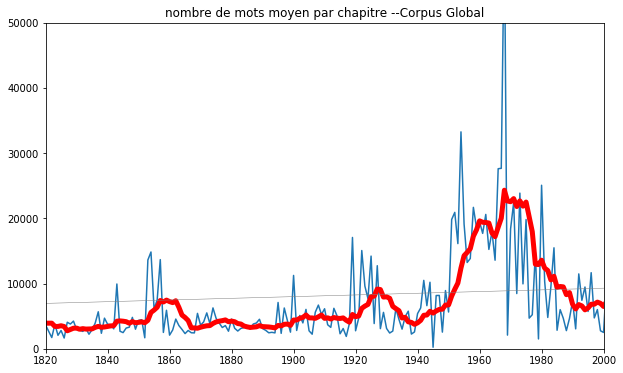

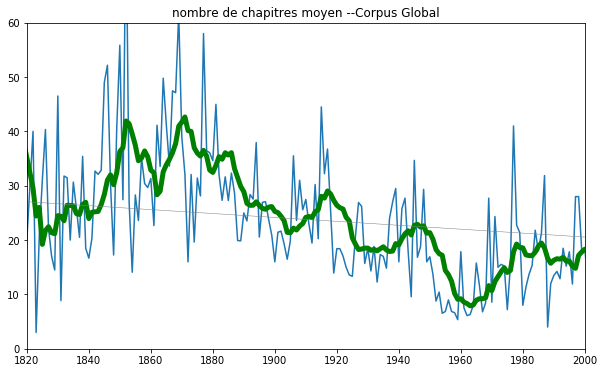

In [124]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1820,2000]
limitsWord=[0,50000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_global["word"][0],stats_global["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre --Corpus Global")
plot_stats(stats_global["chapter"][0],stats_global["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen --Corpus Global")

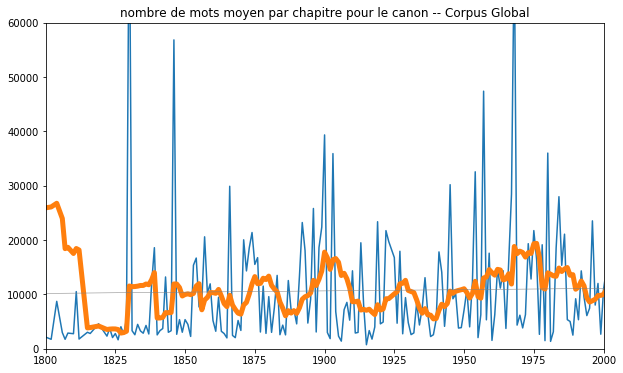

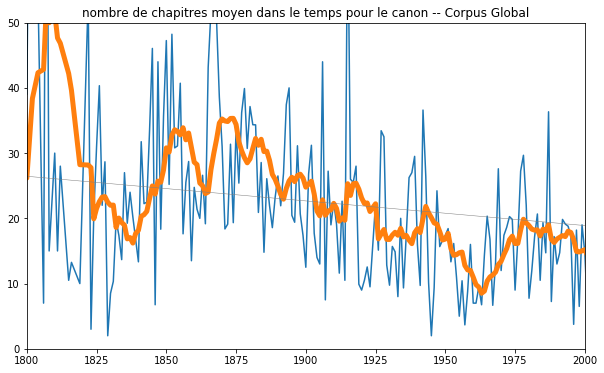

In [54]:
stats_canon=pickle.load(open( "stats_global_canon", "rb"))
limitsX=[1800,2000]
limitsWord=[0,60000]
limitsChap=[0,50]
sliding=10
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,"nombre de mots moyen par chapitre pour le canon -- Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX,limitsChap,sliding,"nombre de chapitres moyen dans le temps pour le canon -- Corpus Global")

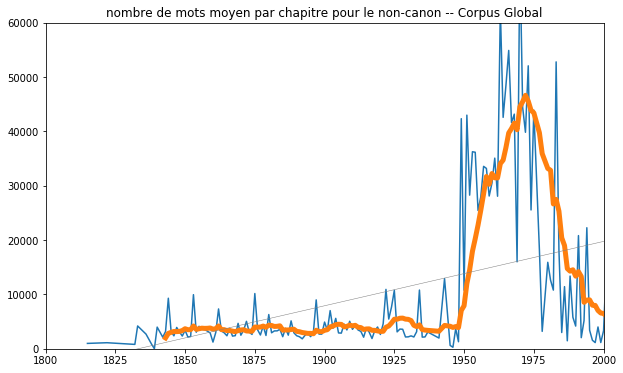

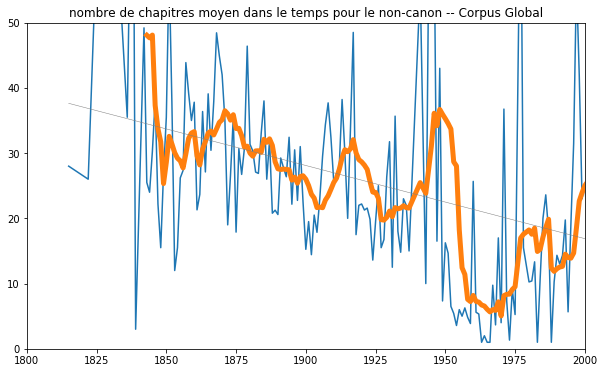

In [57]:
stats_canon=pickle.load(open( "stats_global_non-canon", "rb"))
limitsX=[1800,2000]
limitsWord=[0,60000]
limitsChap=[0,50]
sliding=10
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,"nombre de mots moyen par chapitre pour le non-canon -- Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX,limitsChap,sliding,"nombre de chapitres moyen dans le temps pour le non-canon -- Corpus Global")

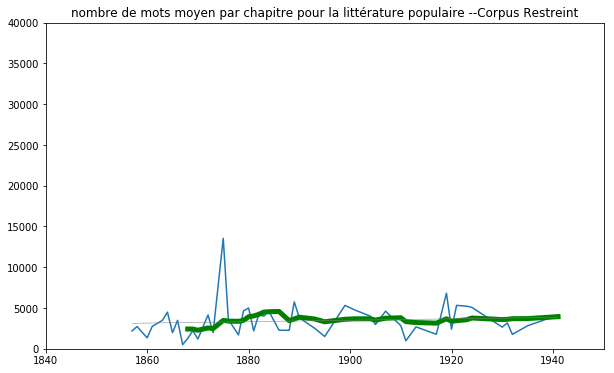

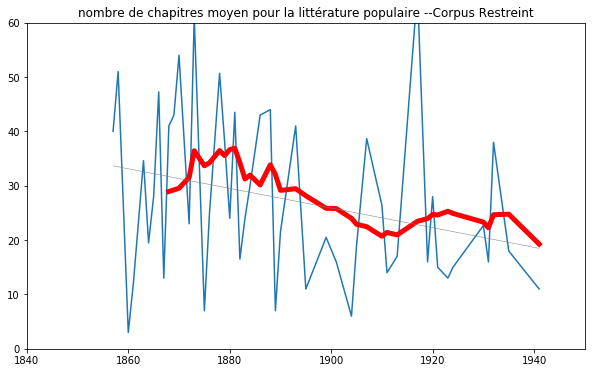

In [19]:
stats_canon=pickle.load(open( "stats_global_populaire", "rb"))
limitsX=[1840,1950]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour la littérature populaire --Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour la littérature populaire --Corpus Global")

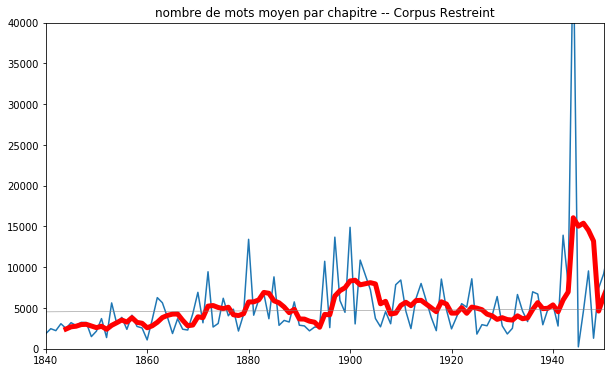

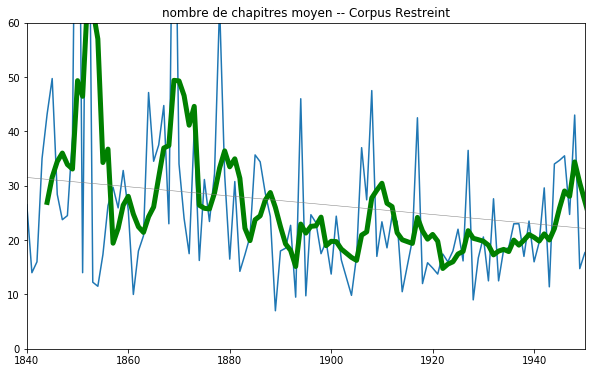

In [39]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,1950]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=5
color=['r','g']
plot_stats(stats_global["word"][0],stats_global["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre -- Corpus Restreint")
plot_stats(stats_global["chapter"][0],stats_global["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen -- Corpus Restreint")

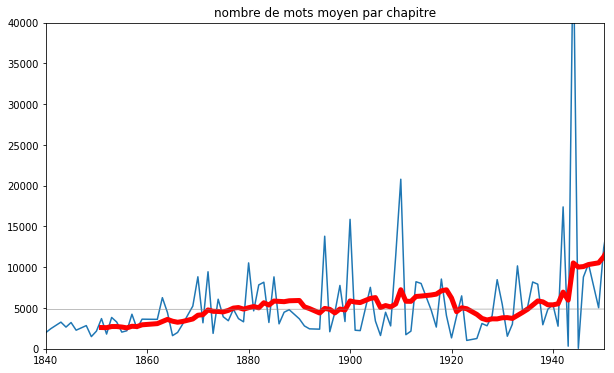

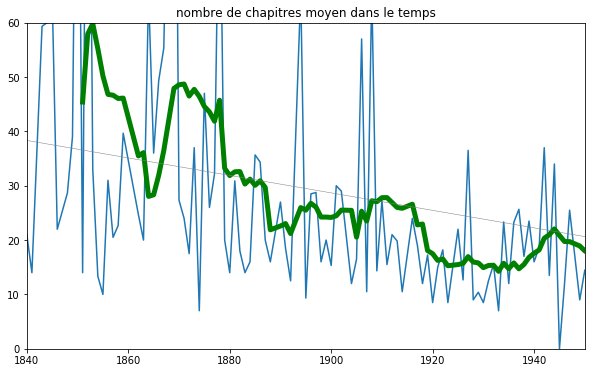

In [38]:
stats_canon=pickle.load(open( "stats_rest_canon", "rb"))
limitsX=[1840,1950]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps")

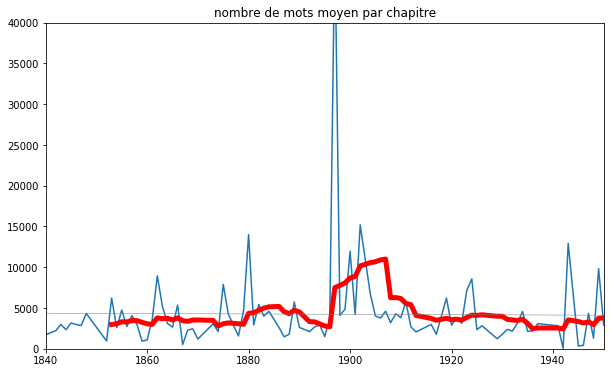

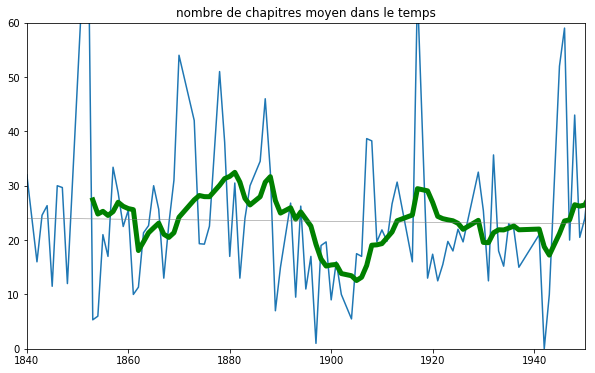

In [102]:
stats_canon=pickle.load(open( "stats_rest_non-canon", "rb"))
limitsX=[1840,1950]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps")

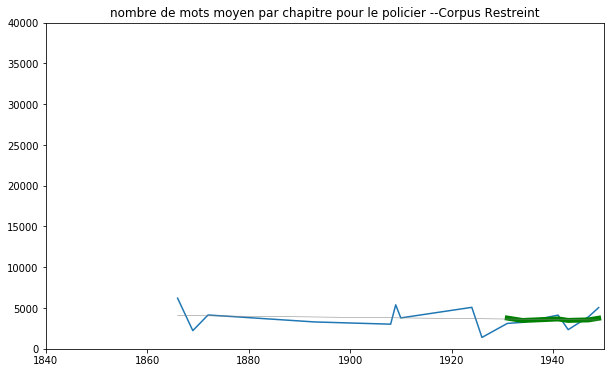

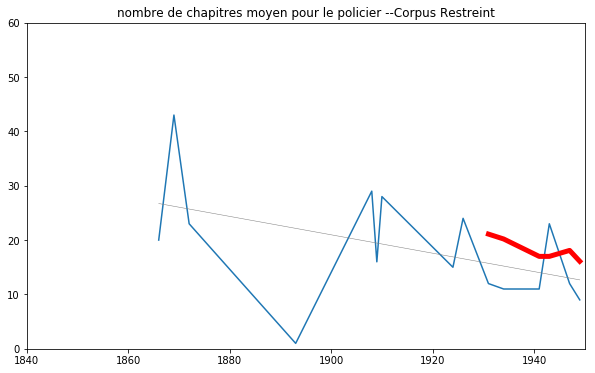

In [108]:
stats_canon=pickle.load(open( "stats_rest_policier", "rb"))
limitsX=[1840,1950]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour le policier --Corpus Restreint")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour le policier --Corpus Restreint")

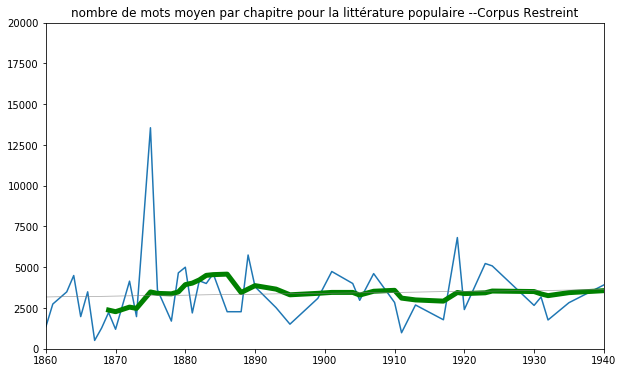

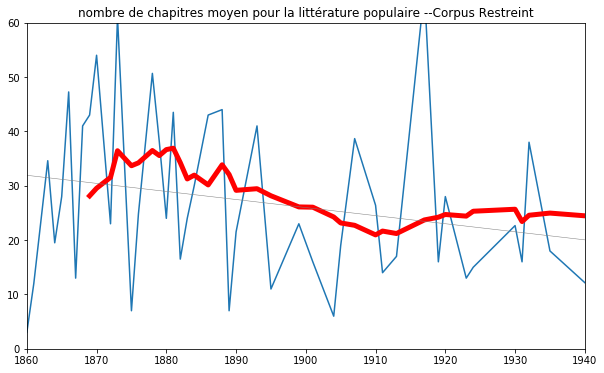

In [17]:
stats_canon=pickle.load(open( "stats_rest_populaire", "rb"))
limitsX=[1860,1940]
limitsWord=[0,20000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour la littérature populaire --Corpus Restreint")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour la littérature populaire --Corpus Restreint")

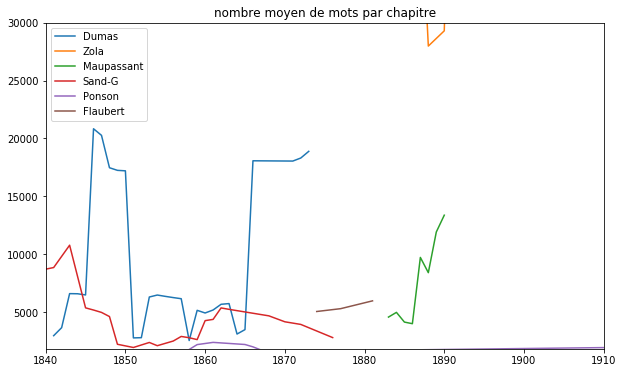

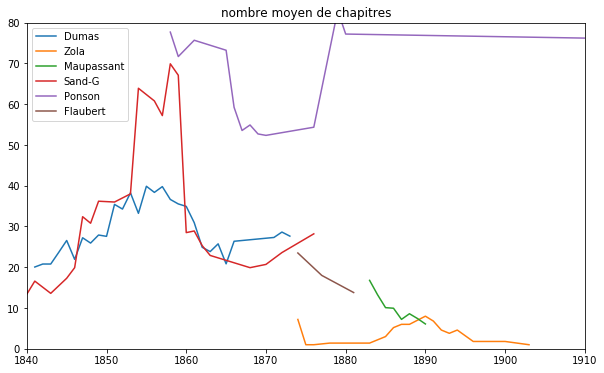

In [39]:
stats_authors=pickle.load(open("stats_authors","rb"))
multiple_plots(stats_authors)

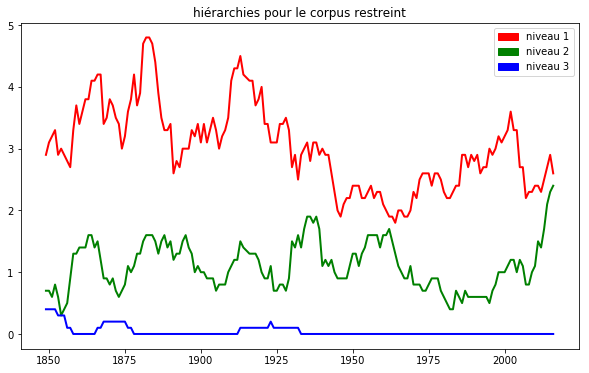

In [38]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,1950]
limitsWord=[0,500]
color=['r','g','b']
sliding=10
hierarchy_plots(stats_global["divs"],limitsX,limitsWord, sliding, color, "hiérarchies pour le corpus restreint")

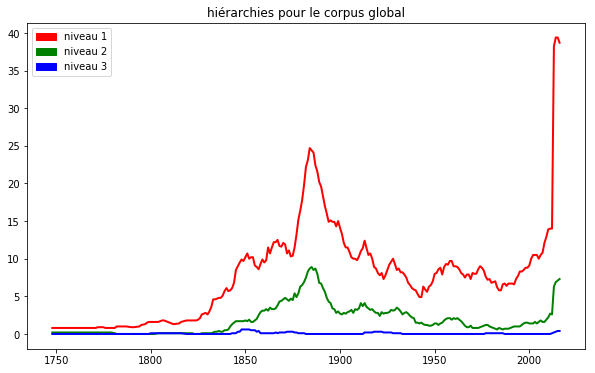

In [125]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1840,1950]
limitsWord=[0,500]
color=['r','g','b']
sliding=10
hierarchy_plots(stats_global["divs"],limitsX,limitsWord, sliding, color, "hiérarchies pour le corpus global")

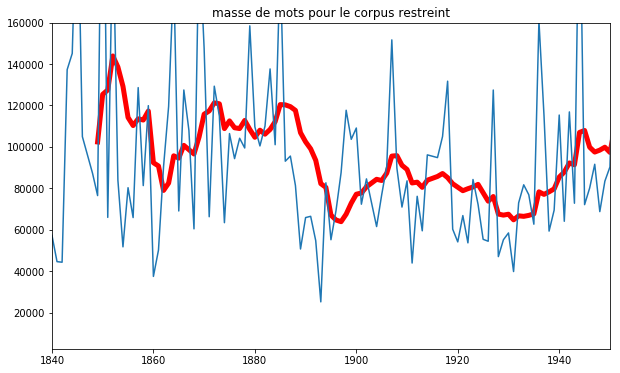

In [111]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,1950]
limitsWord=[2500,160000]
color='r'
sliding=10
simple_plot(stats_global["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint")

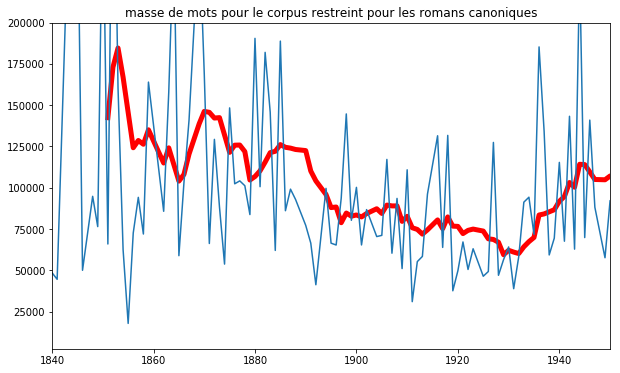

In [119]:
stats_canon=pickle.load(open("stats_rest_canon", "rb"))
limitsX=[1840,1950]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint pour les romans canoniques")

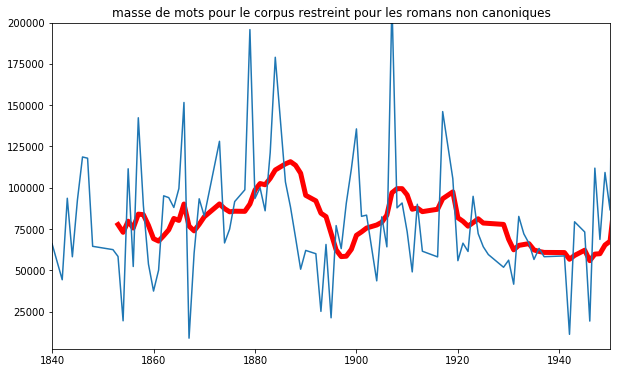

In [121]:
stats_non_canon=pickle.load(open("stats_rest_non-canon", "rb"))
limitsX=[1840,1950]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_non_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint pour les romans non canoniques")